In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
def dirfiles(img_path, img_ext,full=False):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    return img_names

In [3]:
def equalizeHSV(hsv):
    Khsv = hsv.copy()
    Khsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    return Khsv

def laplacian(channel):
    laplacian = cv2.Laplacian(channel, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))
    
    _, smooth_mask = cv2.threshold(laplacian, 20, 255, cv2.THRESH_BINARY)
    image_cleaned = cv2.medianBlur(smooth_mask, 7) 
    
    return image_cleaned

def greenMask(hsv):
    lower_green = np.array([35, 50, 0])  # Verde claro
    upper_green = np.array([108, 254, 254])  # Verde oscuro
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    return mask_green

def GLIMasktemp(image):
    red = image[:, :, 2].astype(float)
    green = image[:, :, 1].astype(float)
    blue = image[:, :, 0].astype(float)
    GLI = (2 * green - red - blue ) / (2* green + red + blue + 1e-6)

    GLI_normalized = cv2.normalize(GLI, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    GLI_normalized = cv2.medianBlur(GLI_normalized, 3)
    return GLI_normalized

def GLIMask(image):
    red = image[:, :, 2].astype(float)
    green = image[:, :, 1].astype(float)
    blue = image[:, :, 0].astype(float)
    
    # Calcular GLI
    GLI = (2 * green - red - blue) / (2 * green + red + blue + 1e-6)

    # Eliminar los valores negativos
    GLI[GLI < 0] = 0

    # Normalizar los valores positivos
    GLI_normalized = cv2.normalize(GLI, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Aplicar un filtro de mediana para suavizar
    GLI_normalized = cv2.medianBlur(GLI_normalized, 3)
    
    return GLI_normalized

def validateContours(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(mask)
    
    image_area = final_mask.shape[0] * final_mask.shape[1]

    valid_contours = []
    prediction = False

    total_valid_contour_area = 0
    # Iterar sobre los contornos
    for contour in contours:
        # Calcular propiedades del contorno
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0
        inverse_aspect_ratio = float(h) / w if w > 0 else 0
        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        bounding_box_area = w * h
        fill_ratio = area / bounding_box_area if bounding_box_area > 0 else 0

        # Filtrar por área, proporción de aspecto y circularidad
        if (area >= 500 and
                aspect_ratio <= 3.0 and
                inverse_aspect_ratio <= 3.0 and
                fill_ratio > 0.2 and 
                circularity < 0.4):
            valid_contours.append(contour)  # Agregar contorno válido a la lista
            total_valid_contour_area += area

    # Si hay más de un contorno válido, dibuja los contornos
    if total_valid_contour_area >= 0.2 * image_area:
        for contour in valid_contours:
            prediction = True
            cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    return final_mask, prediction

def highlightImage(image, final_mask):
    red_image = np.zeros_like(image, dtype=np.uint8)
    red_image[:, :] = [255, 0, 0]

    masked_red = cv2.bitwise_and(red_image, red_image, mask=final_mask)

    highlighted_image = cv2.addWeighted(image, 1.0, masked_red, 0.2, 0)

    return highlighted_image

In [4]:
def modeloPropio(image, eq= False):
    # 1. Convertir a otro espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 2. Equalizar la imagen
    hsv = equalizeHSV(hsv)

    h_channel = hsv[:, :, 0]  # Canal Hue
    s_channel = hsv[:, :, 1]  # Canal Saturation
    v_channel = hsv[:, :, 2]  # Canal Value (Brillo)
    
    # 3. Emplear filtro laplaciano para detectar texturas y filtrar las partes lisas
    image_cleaned = laplacian(v_channel)

    # 4. Crear la mascara para los colores verdes
    mask_green = greenMask(hsv)
    
    # 5. Crear la mascara de GLI
    GLI = GLIMask(image)

    GLI_mean = np.mean(GLI)
    
    # 6. Combinar las mascaras y filtrar los contornos 
    _, GLI_mask = cv2.threshold(GLI, GLI_mean, 255, cv2.THRESH_BINARY)
    combined_mask = cv2.bitwise_and(mask_green, image_cleaned) 
    combined_mask = cv2.bitwise_and(combined_mask, GLI_mask)

    final_result, prediction = validateContours(combined_mask)    

    return final_result, prediction


In [5]:
wildfire = dirfiles("data/test/wildfire/", '*.jpg', full=True)
nowildfire = dirfiles("data/test/nowildfire/", '*.jpg', full=True)

## Caso de ejemplo para mostrar el proceso

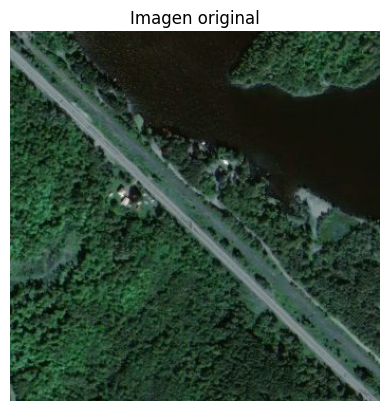

In [63]:
image = cv2.imread("data/test/wildfire/-68.92161,47.39808.jpg")

plt.imshow(image)
plt.title("Imagen original")
plt.axis('off')
plt.show()

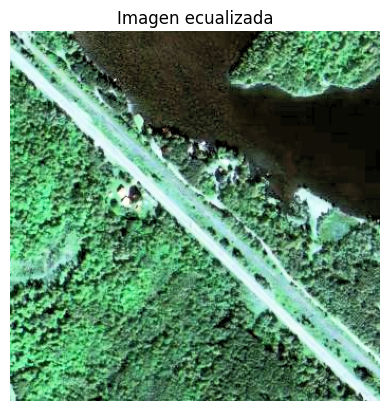

In [64]:
# 1. Convertir a otro espacio de color HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# 2. Equalizar la imagen
hsv = equalizeHSV(hsv)
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))
plt.title("Imagen ecualizada")
plt.axis('off')
plt.show()

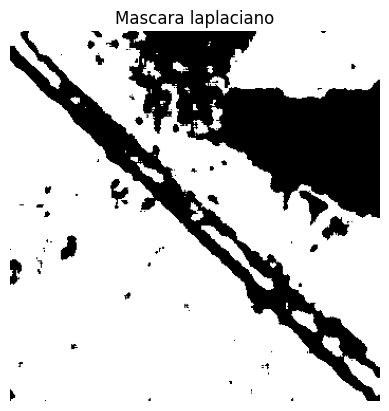

In [65]:
h_channel = hsv[:, :, 0]  # Canal Hue
s_channel = hsv[:, :, 1]  # Canal Saturation
v_channel = hsv[:, :, 2]  # Canal Value (Brillo)

# 3. Emplear filtro laplaciano para detectar texturas y filtrar las partes lisas
image_cleaned = laplacian(v_channel)

plt.imshow(image_cleaned, cmap='gray')
plt.title("Mascara laplaciano")
plt.axis('off')
plt.show()

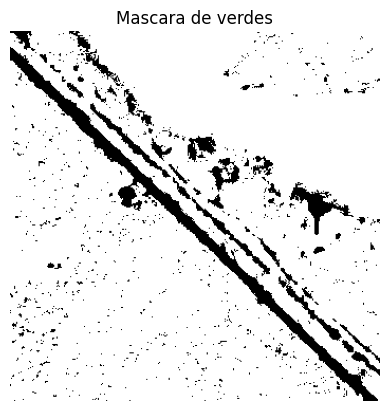

In [66]:
# 4. Crear la mascara para los colores verdes
mask_green = greenMask(hsv)

plt.imshow(mask_green, cmap='gray')
plt.title("Mascara de verdes")
plt.axis('off')
plt.show()

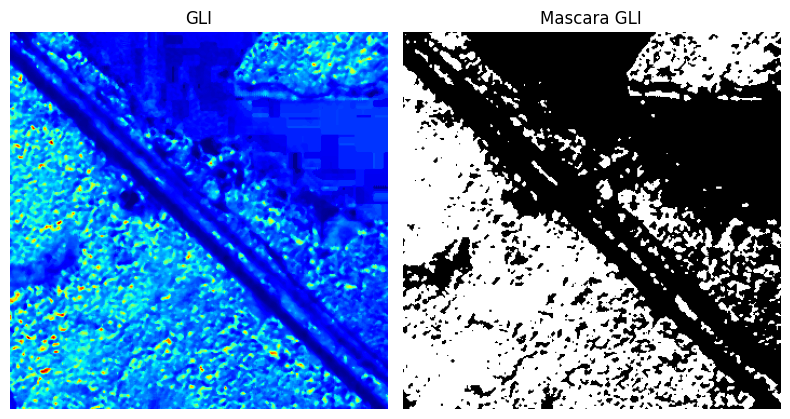

In [67]:
# 5. Crear la mascara de GLI
GLI = GLIMask(image)

GLI_mean = np.mean(GLI)

# 6. Combinar las mascaras y filtrar los contornos 
_, GLI_mask = cv2.threshold(GLI, GLI_mean, 255, cv2.THRESH_BINARY)

fig, axes = plt.subplots(1, 2, figsize=(8, 6))  # 2 filas y 3 column

# Mostrar las imágenes en el grid de subgráficas (sin pred)
axes[0].imshow(GLI, cmap='jet')  # Mostrar `hi`
axes[0].set_title("GLI")  # Título de la subimagen
axes[0].axis('off')  # Ocultar los ejes

axes[1].imshow(GLI_mask, cmap='gray')  # Mostrar `hi`
axes[1].set_title("Mascara GLI")  # Título de la subimagen
axes[1].axis('off')  # Ocultar los ejes

plt.tight_layout()
plt.show()

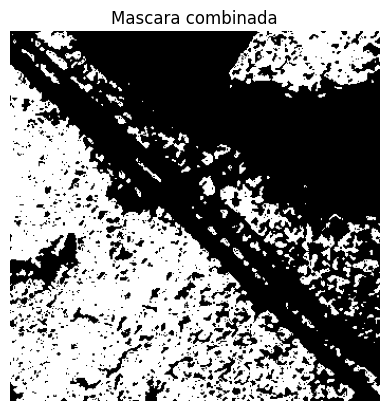

In [68]:
combined_mask = cv2.bitwise_and(mask_green, image_cleaned) 
combined_mask = cv2.bitwise_and(combined_mask, GLI_mask)

plt.imshow(combined_mask, cmap='gray')
plt.title("Mascara combinada")
plt.axis('off')
plt.show()

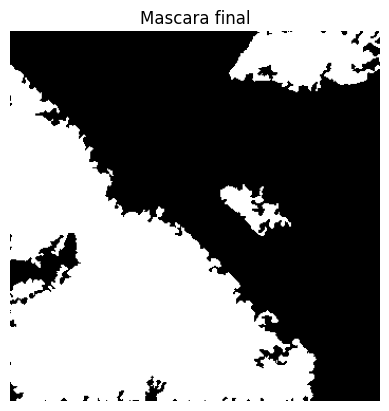

In [69]:

final_mask, prediction = validateContours(combined_mask)

plt.imshow(final_mask, cmap='gray')
plt.title("Mascara final")
plt.axis('off')
plt.show()

Predicción: Zona propensa a incendios


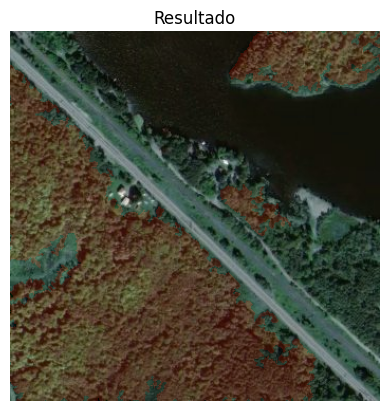

In [70]:
if prediction:
    prediction_text = "Zona propensa a incendios"
else:
    prediction_text = "Zona no propensa a incendios"


print(f"Predicción: {prediction_text}")

resultado = highlightImage(image, final_mask)

plt.imshow(resultado)
plt.title("Resultado")
plt.axis('off')
plt.show()

## Resultados

In [6]:
# Etiquetas reales (1 = wildfire, 0 = no wildfire)
ground_truth = [1] * len(wildfire) + [0] * len(nowildfire)

# Inicializar las predicciones
predictions = []

# Procesar las imágenes de 'wildfire' (etiqueta real = 1)
for path in wildfire:
    image = cv2.imread(path)
    res, pred = modeloPropio(image)
    predictions.append(1 if pred else 0)  # 1 para predicción positiva, 0 para negativa

# Procesar las imágenes de 'nowildfire' (etiqueta real = 0)
for path in nowildfire:
    image = cv2.imread(path)
    res, pred = modeloPropio(image)
    predictions.append(0 if not pred else 1)  # 0 para predicción negativa, 1 para positiva



Premature end of JPEG file


Total imágenes: 6300

--- Métricas ---
Accuracy: 0.83
Precision: 0.84
Recall: 0.85
F1 Score: 0.84


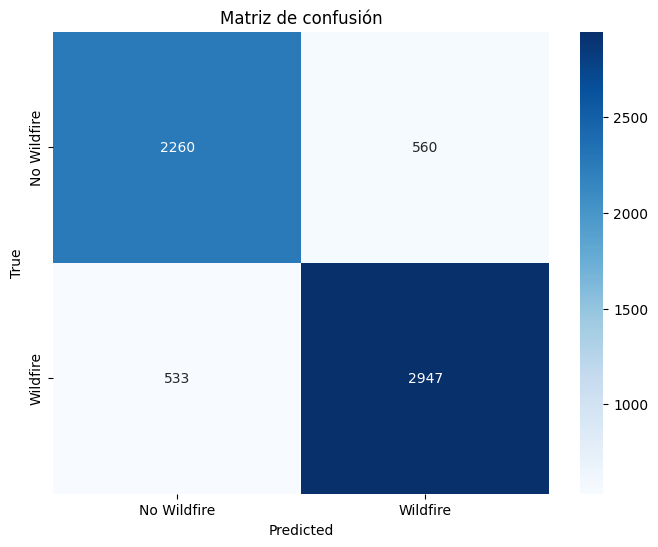

In [7]:
accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)
conf_matrix = confusion_matrix(ground_truth, predictions)

# Resultados
print(f"Total imágenes: {len(nowildfire) + len(wildfire)}")
print("\n--- Métricas ---")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusión')
plt.show()

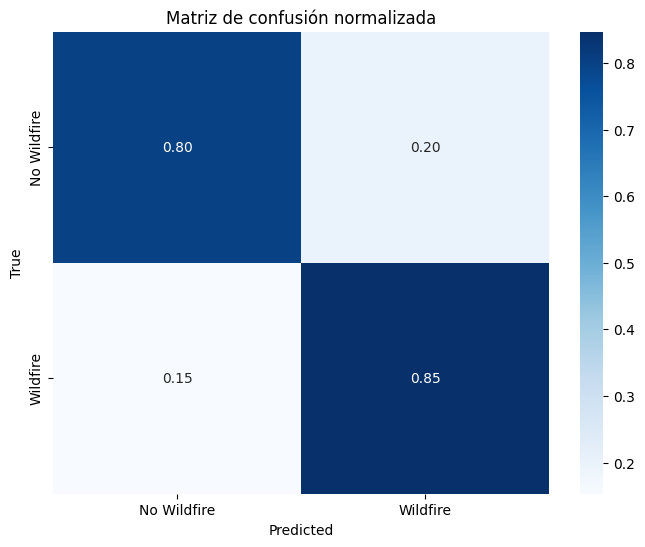

In [40]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusión normalizada')
plt.show()